# **ORIGINAL KLUE_STS FINE-TUNING**

#### CROSS-ENCODER방식을 이용해 학습 한 예제

* 기존 한국어 STS Benchmark dataset인 KLUE_STS를 BERT에 finetuning하고 성능을 체크, 문제점을 찾는 과정 
* hugging-face에 업로드 되어있는 pretrained model인 klue-roberta-base를 사용



### Import libraries

In [ ]:
! pip install sentence-transformers datasets

In [3]:
import numpy as np
import pandas as pd
import math
import logging
from datetime import datetime

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator, CEBinaryAccuracyEvaluator, CEBinaryClassificationEvaluator

from sentence_transformers.readers import InputExample




from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# torch 시드고정 
import torch
import random
import torch.backends.cudnn as cudnn


seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)

In [5]:
# 학습경과 모니터링하는 logger 초기화
from importlib import reload
reload(logging)

logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG,
    handlers=[LoggingHandler()],
)

In [6]:
logging.info('This is an info message')

2022-12-20 16:34:20 - This is an info message


### Load Model

#### cross-encoder 형식으로 pretrained model 로드 

In [7]:
# 새로운 모델 학습시 모델 초기화

from sentence_transformers.cross_encoder import CrossEncoder

cross_encoder = CrossEncoder("klue/roberta-base", num_labels=1)

num_epochs=3
train_batch_size = 32

model_save_path = "/home/sol3sts/removed_mean_cross_encoder_" + "-" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifie

### Load Data (KLUE-STS)

* 기존 KLUE dataset은 testset을 공개하지 않음. 
* devset으로 공개되어있는 500여개의 set을 testset으로 사용하고 devset의 분포와 동일한 비율로 testset에서 추출하여 validationset으로 사용 
* validation set을 추출시, 라벨별 비율이 devset과 동일하도록 추출 

In [8]:
## Load Original KLUE-dataset ## 
## train = klue-train ##
## eval = klue-dev ##

train = pd.read_csv('/home/sol3sts/dataset/KLUE_STS_train (2).csv')
eval = pd.read_csv('/home/sol3sts/dataset/KLUE_STS_val (2).csv')

In [9]:
# devset을 testset으로 설정 
test = eval

In [10]:
# devset분포 확인해서 동일한 분포로 trainset에서 새로운 valset 추출 
val_ratio = (eval.groupby('labels.label').size() / eval.groupby('labels.label').size().sum()).to_frame('ratio')
val_ratio['number']= round(val_ratio['ratio'] * (len(train) *0.05)).astype(int) # train데이터의 5%를 val로 사용 
val_ratio 

,ratio,number
labels.label,,
0.0,0.021195,12
0.1,0.021195,12
0.2,0.021195,12
0.3,0.021195,12
0.4,0.021195,12
0.5,0.021195,12
0.6,0.021195,12
0.7,0.021195,12
0.8,0.021195,12


In [11]:
#creating val_set 

# seed 설정 

val = pd.DataFrame()
label = list(set(train['labels.label'].values))

for i in label:
  sample = train.loc[train['labels.label']==i].sample(n=val_ratio['number'][i], random_state = 0)
  val = pd.concat([val,sample])

val

,Unnamed: 0,guid,source,sentence1,sentence2,labels.label,label,labels.binary-label
3212,3212,klue-sts-v1_train_03212,policy-sampled,앞서 조사팀은 작년 8~10월 서울지역에서 신고된 주택거래 신고 내역에 대한 1·2...,"중대본은 신도 명단이 확보되는 대로 즉각 전국 보건소와 지자체 등에 배포, 관할 지...",0.0,0.000000,0
7409,7409,klue-sts-v1_train_07409,policy-sampled,"당분간 격일로 복지부 등 관계부처, 의료계, 유통업체 등과 상황점검 회의를 통해 수...","둘째, 도로, 철도 등 공공 인프라를 디지털화하겠습니다.",0.0,0.000000,0
9306,9306,klue-sts-v1_train_09306,policy-sampled,"2020학년도 신학기 시작 시점에서 총 5주의 휴업이 실시됨에 따라 유치원, 어린이...",이에따라 코로나19로 직간접 피해를 입은 중소기업과 소상공인의 대출은 최소 6개월 ...,0.0,0.000000,0
2259,2259,klue-sts-v1_train_02259,airbnb-sampled,마침내 프라하에서의 모든 일정은 망가졌습니다.,그리고 중간층의 욕실은 하수구냄새가 올라왔습니다.,0.0,0.000000,0
2937,2937,klue-sts-v1_train_02937,paraKQC-sampled,라니냐 발생 시 해수면의 온도 하강 폭은 어때?,서울 대기질은 어떤 사이트에서 확인할 수 있는지 궁금합니다.,0.0,0.000000,0
...,...,...,...,...,...,...,...,...
9962,9962,klue-sts-v1_train_09962,airbnb-rtt,국립박물관 5분거리로 위치가 매우 좋습니다.,국립박물관에서 5분 거리에 위치해 있습니다.,3.4,3.428571,1
1833,1833,klue-sts-v1_train_01833,paraKQC-para,학교 성적표는 메일로 받는게 우편보다 편하고 좋을거야.,학교 성적표를 기존 우편 대신 메일로 받아보세요.,3.4,3.428571,1
8799,8799,klue-sts-v1_train_08799,policy-rtt,"지상파와 유료 방송 간 중간광고, 가상광고, 간접광고 등 차별적 광고 규제도 해소할...","그것은 또한 중간 광고, 가상 광고, 그리고 지상파와 유료 방송 사이의 간접 광고와...",3.4,3.400000,1
5197,5197,klue-sts-v1_train_05197,policy-rtt,인공지능 시대를 활짝 열고 있는 대한민국 인공지능의 주역 여러분들을 국민들과 함께 ...,인공지능 시대를 열고 있는 한국 인공지능의 리더 여러분들을 응원합니다.,3.4,3.428571,1


In [12]:
# 학습데이터 개수 확인 
train = train.drop(val.index)
len(train), len(val), len(test)

(11098, 570, 519)

### 학습데이터 / 평가데이터 분포 확인 

* testset의 label 불균형 , val/test set은 균형을 이루는 모습

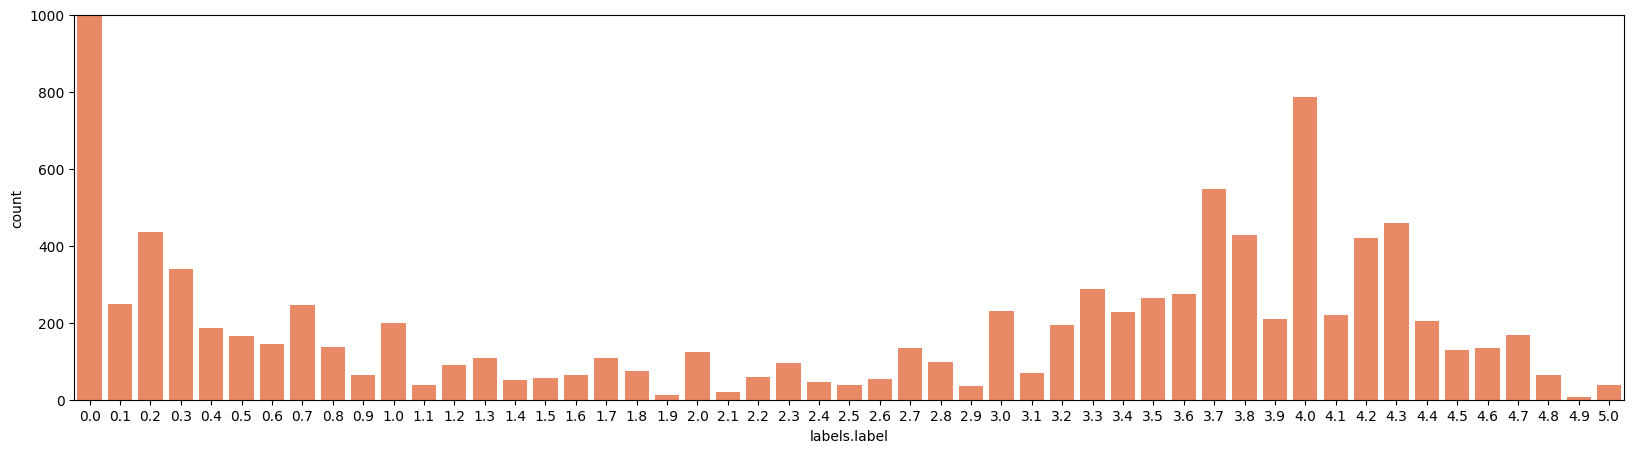

In [14]:
# trainset 분포 확인 
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(20,5))


sns.countplot(x = train['labels.label'],color='#FF7F50')

ax.set(ylim=(0, 1000))
plt.show()

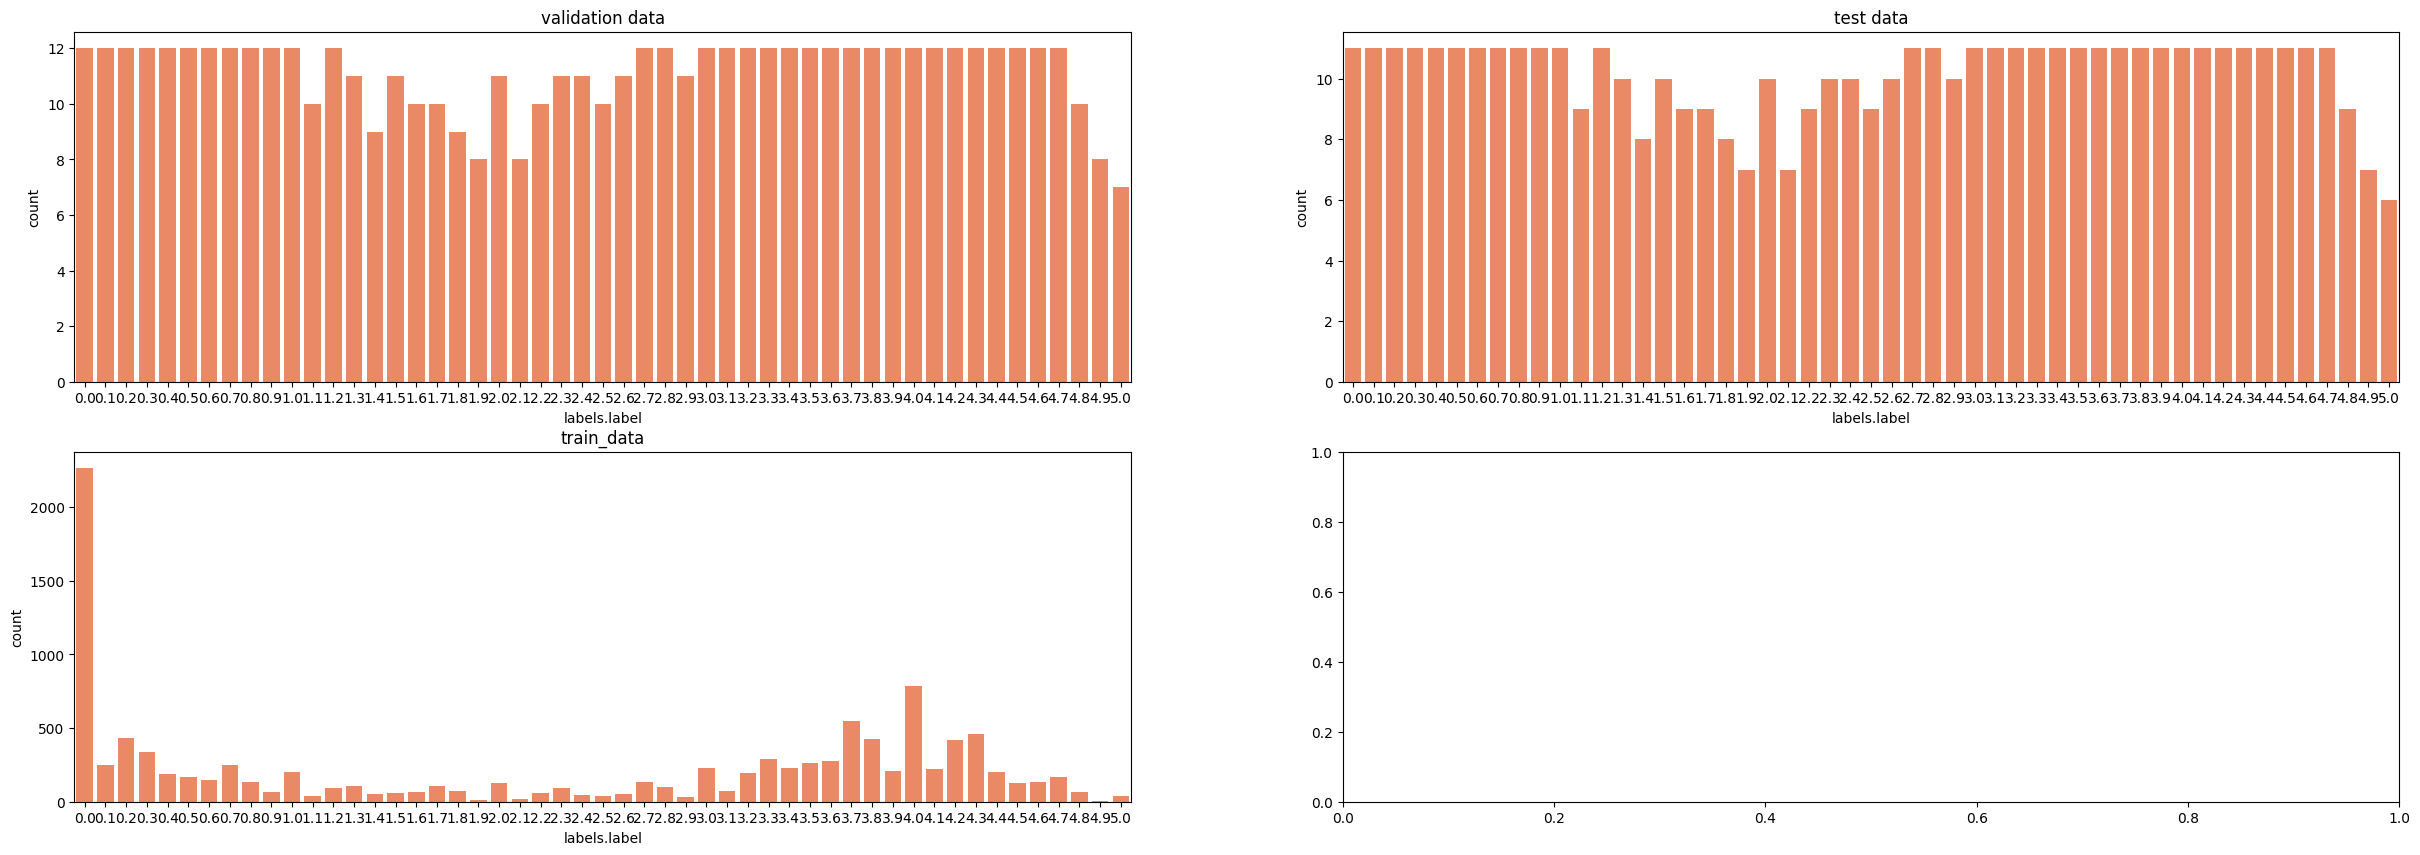

In [18]:
# 전체셋 분포 확인 
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(30,10))


sns.countplot(x = val['labels.label'],ax=ax[0,0],color='#FF7F50')
sns.countplot(x = test['labels.label'],ax=ax[0,1],color='#FF7F50')
sns.countplot(x = train['labels.label'],ax=ax[1,0],color='#FF7F50')

ax[0,0].set_title("validation data")
ax[0,1].set_title("test data")
ax[1,0].set_title('train_data')

plt.show()

### 모델 입력 형태로 바꿔주기 

* InputExample을 사용하여 각 row를 모델에 input으로 들어갈 수 있는 입력형태로 바꿔주기 

In [19]:
# 'labels.label' column만 선택하여 소수점 반올림된 열을 lable로 사용'

train = train.reset_index()
train = train[['sentence1','sentence2','labels.label']]
val = val[['sentence1','sentence2','labels.label']]
test = test[['sentence1','sentence2','labels.label']]

In [20]:
# 모델에 입력형태로 바꿔주기 (train, val, test)

input_examples_train=[]
for i in tqdm(range(len(train))):
  sentence1 = train.values[i][0]
  sentence2 = train.values[i][1]
  score = train.values[i][2]/5.0 # 0-1사이로 정규화 
  input_examples_train.append(InputExample(texts=[sentence1, sentence2], label=score))

input_examples_val=[]
for i in tqdm(range(len(val))):
  sentence1 = val.values[i][0]
  sentence2 = val.values[i][1]
  score = val.values[i][2]/5.0
  input_examples_val.append(InputExample(texts=[sentence1, sentence2], label=score))

input_examples_test=[]
for i in tqdm(range(len(test))):
  sentence1 = test.values[i][0]
  sentence2 = test.values[i][1]
  score = test.values[i][2]/5.0
  input_examples_test.append(InputExample(texts=[sentence1, sentence2], label=score))

  0%|          | 0/11098 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/519 [00:00<?, ?it/s]

In [21]:
sts_train_examples = input_examples_train
sts_val_examples = input_examples_val
sts_test_examples = input_examples_test

In [22]:
# 형태 확인 
sts_val_examples[0].texts, sts_val_examples[0].label

(['앞서 조사팀은 작년 8~10월 서울지역에서 신고된 주택거래 신고 내역에 대한 1·2차 조사를 벌인 바 있다.',
  '중대본은 신도 명단이 확보되는 대로 즉각 전국 보건소와 지자체 등에 배포, 관할 지역에 주소지를 둔 신도들을 대상으로 코로나19 감염증 조사를 개시할 예정이다.'],
 0.0)

In [23]:
# 개수 확인 
len(input_examples_train), len(input_examples_val), len(input_examples_test)

(11098, 570, 519)

### Evaluator 정의 (cross encoder)

* model 검증에 사용할 Evaluator를 정의
* 각 batch 마다 validation을 수행하여 모델 학습결과를 평가 / 수정
* 학습을 전부 마친후 모델 평가에 사용할 test-evaluator도 따로 정의 

In [24]:
## CROSS-ENCODER ##
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator


# Train Dataloader
train_dataloader = DataLoader(
    sts_train_examples,
    shuffle=True,
    batch_size=train_batch_size, 
)

# Evaluator CEcorrelationEvaluator
logging.info("Creating cross-encoder evaluators")
val_evaluator = CECorrelationEvaluator.from_input_examples(
    sts_val_examples,
    name="sts-cross_encoder-val",
)


#Evaluator by sts-test
test_evaluator = CECorrelationEvaluator.from_input_examples(
    sts_test_examples,
    name="sts-cross_encoder-test",
)

2022-12-20 16:48:03 - Creating cross-encoder evaluators


###  Model Training

In [25]:
#  GPU memory확인 
! nvidia-smi

Tue Dec 20 16:49:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.88       Driver Version: 418.88       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        On   | 00000000:3B:00.0 Off |                  N/A |
| 46%   31C    P8     6W / 105W |     11MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P4000        On   | 00000000:D8:00.0 Off |                  N/A |
| 46%   34C    P8     5W / 105W |    950MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [26]:
# CUDA OUT OF MEMORY 에러 방지하기 위해 메모리 확인 후 캐쉬 지워주기 

import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [27]:
# GPU 할당 변경하기

GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

# Current cuda device:  0


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [29]:
## Fit CROSS-ENCODER ## 


# linear learning-rate warmup steps
warmup_steps = math.ceil(len(train_dataloader) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps)) # 학습 로그 표시 



# Training
cross_encoder.fit(
    train_dataloader = train_dataloader,
    evaluator=val_evaluator,
    epochs=num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    optimizer_params = {'lr':5e-5},
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    show_progress_bar = True
)

2022-12-20 16:50:47 - Warmup-steps: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/347 [00:00<?, ?it/s]

Iteration:   0%|          | 0/347 [00:00<?, ?it/s]

Iteration:   0%|          | 0/347 [00:00<?, ?it/s]

In [30]:
model_save_path 

'/home/sol3sts/removed_mean_cross_encoder_-2022-12-20_16-34-39'

### cross-encoder-test_evaluating

* 정의한 test-evaluaotr로 testset 평가하기 / spearman correlation

In [31]:
# test 
cross_encoder = CrossEncoder(model_save_path)
print("SPEARMAN CORR:",test_evaluator(cross_encoder))

SPEARMAN CORR: 0.9285123080130815


### testset에 대한 자세한 성능평가 

    - testset데이터를 bin별로 나누어 특정 영역의 성능이 얼마나 나오는지를 측정하고 부족하게 학습되는 부분이 어디인지 찾기 

* Pearson R 
* Spearman R


* F1-Score
* ACC 

* bin별 성능평가 

In [32]:
test.head()

,sentence1,sentence2,labels.label
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.9
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.4
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.3
3,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.",3.7
4,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,2.5


In [33]:
# crossencoder의 predict함수 이용하여 새로운 데이터에 대한 prediction 

pairs_all = list(zip(test['sentence1'], test['sentence2']))

scores_all = cross_encoder.predict(pairs_all,
                               show_progress_bar = True)

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [34]:
# 모델 예측값을 silver_label 형태로 달아주기 
# 소수점 첫째자리 반올림한 라벨로 기입  

test['silver_label'] = np.round((scores_all * 5).tolist(), 1)

test

/home/sol3sts/.conda/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,sentence1,sentence2,labels.label,silver_label
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.9,4.8
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.4,1.9
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.3,1.4
3,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.",3.7,3.8
4,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,2.5,2.5
...,...,...,...,...
514,"문체부는 이를 연차적으로 확대, 시행해 학교운동부와 스포츠클럽 간의 연계를 강화한다.",문화체육관광부는 학교스포츠학과와 스포츠클럽의 연계성을 강화하기 위해 매년 이 프로그...,2.2,3.7
515,일단 정확한 정보와 빠른 답변이 정말 좋았습니다.,호스트의 빠른 답변과 유용한 정보들이 정말 좋습니다.,2.8,3.0
516,게스트에 대한 배려가 묻어나는 시설들이었습니다.,우선 공간에 대한 센스가 돋보이는 곳이었습니다.,0.3,2.4
517,밤하늘을 배경으로 ‘비대면 드론쇼’도 펼쳐진다.,‘비대면 실감형 문화공연 플랫폼’ 개념도.,0.3,0.7


In [35]:
# 피어슨 / 스피어만 상관계수 계산 

print("'Spearman correlation' for whole test data:",test.corr(method='spearman')['silver_label'][0])
print("'Pearson correlation' for whole test data:",test.corr(method='pearson')['silver_label'][0])

'Spearman correlation' for whole test data: 0.9286228574203941
'Pearson correlation' for whole test data: 0.9276207689338025


In [36]:
# confusion matrix 만들기 위해 3.0을 기준으로 정답여부를 trueN/F - falseN/F 구분하여 데이터 나눠주기 

correct=[]
for i in range(len(test)):
  if (test['silver_label'].values[i] >= 3.0) & (test['labels.label'].values[i] >= 3.0):
    correct.append('True_P')
  elif (test['silver_label'].values[i] < 3.0) & (test['labels.label'].values[i] < 3.0):
    correct.append('True_N')
  elif (test['silver_label'].values[i] >= 3.0) & (test['labels.label'].values[i] < 3.0):
    correct.append('False_P')
  else:
    correct.append('False_N')



In [37]:
test['correctness'] = correct

print("whole test data confusion matrix")
print()
print(test['correctness'].value_counts())

whole test data confusion matrix

True_N     240
True_P     211
False_P     59
False_N      9
Name: correctness, dtype: int64


/home/sol3sts/.conda/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
# ACC / F1 score 측정하기 

TP = len(test[test['correctness'] == 'True_P'])
TN = len(test[test['correctness'] == 'True_N'])
FP = len(test[test['correctness'] == 'False_P'])
FN = len(test[test['correctness'] == 'False_N'])

print("precision:", TP/(TP+FP))
print("recall:", TP/(TP+FN))
pc=TP/(TP+FP)
rc=TP/(TP+FN)
print("f1 score:", 2*pc*rc/(pc+rc))
print("acc:", (TP + TN)/ (TP + TN + FP + FN) )

precision: 0.7814814814814814
recall: 0.9590909090909091
f1 score: 0.8612244897959183
acc: 0.8689788053949904


#### Dataset을 0.5단위 bin으로 구분해 구간 만들기 

In [50]:
# train
t = []
for i in range(len(train)):
  if (train['labels.label'].values[i] >= 0.0)  & (train['labels.label'].values[i] <=0.2):
    t.append(0.0)
  elif (train['labels.label'].values[i] >= 0.2)  & (train['labels.label'].values[i] <=0.7):
    t.append(0.5)  
  elif (train['labels.label'].values[i] >= 0.8)  & (train['labels.label'].values[i] <=1.2):
    t.append(1.0)
  elif (train['labels.label'].values[i] >= 1.3)  & (train['labels.label'].values[i] <=1.7):
    t.append(1.5)  
  elif (train['labels.label'].values[i] >= 1.8)  & (train['labels.label'].values[i] <=2.2):
    t.append(2.0)
  elif (train['labels.label'].values[i] >= 2.3)  & (train['labels.label'].values[i] <=2.7):
    t.append(2.5)  
  elif (train['labels.label'].values[i] >= 2.8)  & (train['labels.label'].values[i] <=3.2):
    t.append(3.0)
  elif (train['labels.label'].values[i] >= 3.3)  & (train['labels.label'].values[i] <=3.7):
    t.append(3.5)  
  elif (train['labels.label'].values[i] >= 3.8)  & (train['labels.label'].values[i] <=4.2):
    t.append(4.0)
  elif (train['labels.label'].values[i] >= 4.3)  & (train['labels.label'].values[i] <=4.7):
    t.append(4.5)  
  elif (train['labels.label'].values[i] >= 4.8)  & (train['labels.label'].values[i] <=5.0):
    t.append(5.0)


print(len(t))

train['gold_bin'] = t


train_bin_05 = train[train['gold_bin'] == 0.5]
train_bin_10 = train[train['gold_bin'] == 1.0]
train_bin_15 = train[train['gold_bin'] == 1.5]
train_bin_20 = train[train['gold_bin'] == 2.0]
train_bin_25 = train[train['gold_bin'] == 2.5]
train_bin_30 = train[train['gold_bin'] == 3.0]
train_bin_35 = train[train['gold_bin'] == 3.5]
train_bin_40 = train[train['gold_bin'] == 4.0]
train_bin_45 = train[train['gold_bin'] == 4.5]
train_bin_50 = train[train['gold_bin'] == 5.0]

test
a = []
for i in range(len(test)):
  if (test['labels.label'].values[i] >= 0.0)  & (test['labels.label'].values[i] <=0.2):
    a.append(0.0)
  elif (test['labels.label'].values[i] >= 0.2)  & (test['labels.label'].values[i] <=0.7):
    a.append(0.5)  
  elif (test['labels.label'].values[i] >= 0.8)  & (test['labels.label'].values[i] <=1.2):
    a.append(1.0)
  elif (test['labels.label'].values[i] >= 1.3)  & (test['labels.label'].values[i] <=1.7):
    a.append(1.5)  
  elif (test['labels.label'].values[i] >= 1.8)  & (test['labels.label'].values[i] <=2.2):
    a.append(2.0)
  elif (test['labels.label'].values[i] >= 2.3)  & (test['labels.label'].values[i] <=2.7):
    a.append(2.5)  
  elif (test['labels.label'].values[i] >= 2.8)  & (test['labels.label'].values[i] <=3.2):
    a.append(3.0)
  elif (test['labels.label'].values[i] >= 3.3)  & (test['labels.label'].values[i] <=3.7):
    a.append(3.5)  
  elif (test['labels.label'].values[i] >= 3.8)  & (test['labels.label'].values[i] <=4.2):
    a.append(4.0)
  elif (test['labels.label'].values[i] >= 4.3)  & (test['labels.label'].values[i] <=4.7):
    a.append(4.5)  
  elif (test['labels.label'].values[i] >= 4.8)  & (test['labels.label'].values[i] <=5.0):
    a.append(5.0)

b = []
for i in range(len(test)):
  if (test['silver_label'].values[i] >= 0.0)  & (test['silver_label'].values[i] <=0.2):
    b.append(0.0)
  elif (test['silver_label'].values[i] >= 0.3)  & (test['silver_label'].values[i] <=0.7):
    b.append(0.5)  
  elif (test['silver_label'].values[i] >= 0.8)  & (test['silver_label'].values[i] <=1.2):
    b.append(1.0)
  elif (test['silver_label'].values[i] >= 1.3)  & (test['silver_label'].values[i] <=1.7):
    b.append(1.5)  
  elif (test['silver_label'].values[i] >= 1.8)  & (test['silver_label'].values[i] <=2.2):
    b.append(2.0)
  elif (test['silver_label'].values[i] >= 2.3)  & (test['silver_label'].values[i] <=2.7):
    b.append(2.5)  
  elif (test['silver_label'].values[i] >= 2.8)  & (test['silver_label'].values[i] <=3.2):
    b.append(3.0)
  elif (test['silver_label'].values[i] >= 3.3)  & (test['silver_label'].values[i] <=3.7):
    b.append(3.5)  
  elif (test['silver_label'].values[i] >= 3.8)  & (test['silver_label'].values[i] <=4.2):
    b.append(4.0)
  elif (test['silver_label'].values[i] >= 4.3)  & (test['silver_label'].values[i] <=4.7):
    b.append(4.5)  
  elif (test['silver_label'].values[i] >= 4.8)  & (test['silver_label'].values[i] <=5.0):
    b.append(5.0)

print(len(a), len(b))

#test

test['differ']= np.round(test['labels.label'] - test['silver_label'],1)
test['gold_bin'] = a
test['silver_bin'] = b

test['same_bin']= (test['gold_bin'] == test['silver_bin'])

# bin간의 거리
test['bin_distance'] = test['gold_bin'] - test['silver_bin']

#MSE 측정 

test['SE'] = test['differ']**2 
print("MSE:",sum(test['SE']) / len(test)) 

# make bin
bin_05 = test[test['gold_bin'] == 0.5]
bin_10 = test[test['gold_bin'] == 1.0]
bin_15 = test[test['gold_bin'] == 1.5]
bin_20 = test[test['gold_bin'] == 2.0]
bin_25 = test[test['gold_bin'] == 2.5]
bin_30 = test[test['gold_bin'] == 3.0]
bin_35 = test[test['gold_bin'] == 3.5]
bin_40 = test[test['gold_bin'] == 4.0]
bin_45 = test[test['gold_bin'] == 4.5]
bin_50 = test[test['gold_bin'] == 5.0]

11098
519 519
MSE: 0.33360308285163787


In [53]:
# bin 별로 correlation 평가 

print("Test_Evaluation_Per_Bin")
print( "len = number of test_data,", "ME = mean_error")
print()
print("<bin_0.5>:","pearson:",bin_05.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_05.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_05), "MSE:",round(sum(bin_05['SE']) / len(bin_05),2),"ME:",round(sum(bin_05['differ']) / len(bin_05),2),"len(train):",len(train_bin_05))
print("<bin_1.0>:","pearson:",bin_10.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_10.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_10), "MSE:",round(sum(bin_10['SE']) / len(bin_10),2),"ME:",round(sum(bin_10['differ']) / len(bin_10),2),"len(train):",len(train_bin_10))
print("<bin_1.5>:","pearson:",bin_15.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_15.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_15), "MSE:",round(sum(bin_15['SE']) / len(bin_15),2),"ME:",round(sum(bin_15['differ']) / len(bin_15),2),"len(train):",len(train_bin_15))
print("<bin_2.0>:","pearson:",bin_20.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_20.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_20), "MSE:",round(sum(bin_20['SE']) / len(bin_20),2),"ME:",round(sum(bin_20['differ']) / len(bin_20),2),"len(train):",len(train_bin_20))
print("<bin_2.5>:","pearson:",bin_25.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_25.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_25), "MSE:",round(sum(bin_25['SE']) / len(bin_25),2),"ME:",round(sum(bin_25['differ']) / len(bin_25),2),"len(train):",len(train_bin_25))
print("<bin_3.0>:","pearson:",bin_30.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_30.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_30), "MSE:",round(sum(bin_30['SE']) / len(bin_30),2),"ME:",round(sum(bin_30['differ']) / len(bin_30),2),"len(train):",len(train_bin_30))
print("<bin_3.5>:","pearson:",bin_35.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_35.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_35), "MSE:",round(sum(bin_35['SE']) / len(bin_35),2),"ME:",round(sum(bin_35['differ']) / len(bin_35),2),"len(train):",len(train_bin_35))
print("<bin_4.0>:","pearson:",bin_40.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_40.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_40), "MSE:",round(sum(bin_40['SE']) / len(bin_40),2),"ME:",round(sum(bin_40['differ']) / len(bin_40),2),"len(train):",len(train_bin_40))
print("<bin_4.5>:","pearson:",bin_45.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_45.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_45), "MSE:",round(sum(bin_45['SE']) / len(bin_45),2),"ME:",round(sum(bin_45['differ']) / len(bin_45),2),"len(train):",len(train_bin_45))
print("<bin_5.0>:","pearson:",bin_50.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_50.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_50), "MSE:",round(sum(bin_50['SE']) / len(bin_50),2),"ME:",round(sum(bin_50['differ']) / len(bin_50),2),"len(train):",len(train_bin_50))

Test_Evaluation_Per_Bin
len = number of test_data, ME = mean_error

<bin_0.5>: pearson: 0.14 spaerman: 0.17 len: 55 MSE: 0.53 ME: -0.49 len(train): 1084
<bin_1.0>: pearson: 0.1 spaerman: 0.09 len: 53 MSE: 0.34 ME: -0.27 len(train): 527
<bin_1.5>: pearson: 0.19 spaerman: 0.18 len: 46 MSE: 0.44 ME: -0.33 len(train): 388
<bin_2.0>: pearson: 0.21 spaerman: 0.18 len: 41 MSE: 0.53 ME: -0.46 len(train): 291
<bin_2.5>: pearson: 0.27 spaerman: 0.28 len: 50 MSE: 0.53 ME: -0.55 len(train): 368
<bin_3.0>: pearson: 0.1 spaerman: 0.08 len: 54 MSE: 0.24 ME: -0.31 len(train): 627
<bin_3.5>: pearson: 0.33 spaerman: 0.37 len: 55 MSE: 0.08 ME: 0.02 len(train): 1598
<bin_4.0>: pearson: 0.38 spaerman: 0.43 len: 55 MSE: 0.14 ME: 0.26 len(train): 2064
<bin_4.5>: pearson: 0.19 spaerman: 0.21 len: 55 MSE: 0.32 ME: 0.45 len(train): 1095
<bin_5.0>: pearson: 0.71 spaerman: 0.76 len: 22 MSE: 0.24 ME: 0.42 len(train): 109


In [54]:
# Confusion matrix

# acc / f1

def confusion_matrix(test):

  TP = len(test[test['correctness'] == 'True_P'])
  TN = len(test[test['correctness'] == 'True_N'])
  FP = len(test[test['correctness'] == 'False_P'])
  FN = len(test[test['correctness'] == 'False_N'])
  print("TP:",TP,"TN:",TN,"FP:",FP,"FN",FN)

  
  if (TP + FP) & (TP+FN) ==0:
    return("accuracy:",(TP+TN)/(TP+TN+FP+FN))
  
  else:
    pc=TP/(TP+FP)
    rc=TP/(TP+FN)
    
    return("accuracy:",(TP+TN)/(TP+TN+FP+FN),"precision:", TP/(TP+FP), "recall:", TP/(TP+FN),"f1 score:", 2*pc*rc/(pc+rc))

print("전체 test data")
print()
print("TP = 유사한페어를 유사하다고 정답,", "TN = 유사하지않은 페어를 유사하지 않다고 정답,", "FP=유사하지 않은페어를 유사하다고 오판,", "FN = 유사한페어를 유사하지않다고 오판")
print()
print("1.8-2.2:")
print(confusion_matrix(bin_20))
print()
print("2.3-2.7:")
print(confusion_matrix(bin_25))
print()
print("2.8-3.2:")
print(confusion_matrix(bin_30))
print()
print("3.3-3.7:")
print(confusion_matrix(bin_35))
print()
print("3.8-4.2:")
print(confusion_matrix(bin_40))
print()
print("4.3-4.7:")
print(confusion_matrix(bin_45))
print()
print("4.8-5.0:")
print(confusion_matrix(bin_50))

전체 test data

TP = 유사한페어를 유사하다고 정답, TN = 유사하지않은 페어를 유사하지 않다고 정답, FP=유사하지 않은페어를 유사하다고 오판, FN = 유사한페어를 유사하지않다고 오판

1.8-2.2:
TP: 0 TN: 31 FP: 10 FN 0
('accuracy:', 0.7560975609756098)

2.3-2.7:
TP: 0 TN: 22 FP: 28 FN 0
('accuracy:', 0.44)

2.8-3.2:
TP: 28 TN: 3 FP: 18 FN 5
('accuracy:', 0.5740740740740741, 'precision:', 0.6086956521739131, 'recall:', 0.8484848484848485, 'f1 score:', 0.7088607594936709)

3.3-3.7:
TP: 52 TN: 0 FP: 0 FN 3
('accuracy:', 0.9454545454545454, 'precision:', 1.0, 'recall:', 0.9454545454545454, 'f1 score:', 0.9719626168224299)

3.8-4.2:
TP: 55 TN: 0 FP: 0 FN 0
('accuracy:', 1.0, 'precision:', 1.0, 'recall:', 1.0, 'f1 score:', 1.0)

4.3-4.7:
TP: 54 TN: 0 FP: 0 FN 1
('accuracy:', 0.9818181818181818, 'precision:', 1.0, 'recall:', 0.9818181818181818, 'f1 score:', 0.9908256880733944)

4.8-5.0:
TP: 22 TN: 0 FP: 0 FN 0
('accuracy:', 1.0, 'precision:', 1.0, 'recall:', 1.0, 'f1 score:', 1.0)
